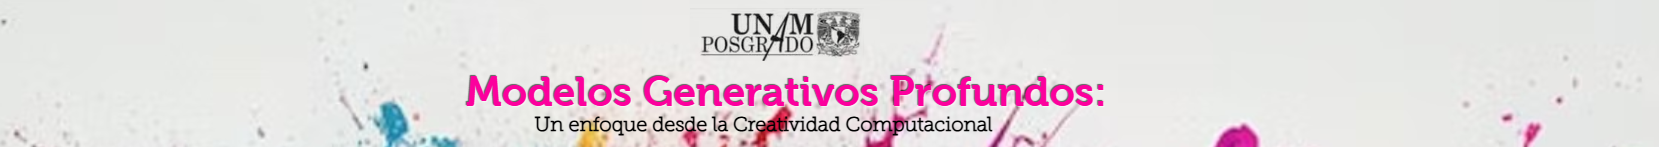

# Modelos basados en energía

En este notebook, recorreremos paso a paso el proceso necesario para entrenar tu propio Energy-Based Model (EBM) con el fin de predecir la distribución de un conjunto de datos de demostración.

In [1]:

base_dir = "."


In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

import random
import matplotlib.pyplot as plt
import os

## 0. Parámetros

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 70
LOAD_MODEL = True

In [4]:
# Cargar los datos
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [5]:
# Preparación de los datos


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

2025-10-24 10:03:43.118883: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-10-24 10:03:43.118904: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-10-24 10:03:43.118908: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
I0000 00:00:1761321823.118919 1259901 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1761321823.118937 1259901 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [8]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Despliega n imágenes aleatorias.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


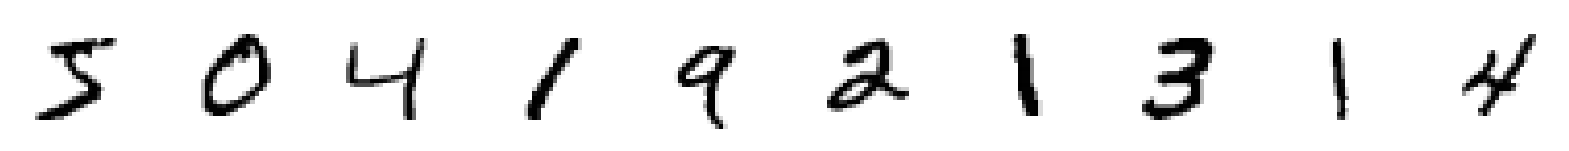

In [9]:
# Muestra algunos ejemplos del conjunto de datos de entrenamiento
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Construir la red EBM

In [10]:
# Define la arquitectura de la red que aprende la función de energía
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

## 2. Configurar una función de muestreo de Langevin

In [11]:
# Función para generar muestras utilizando Dinámicas de Langevin
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 3. Configurar un búfer para almacenar ejemplos

In [12]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [13]:
@tf.keras.utils.register_keras_serializable()
class EBM(models.Model):
    def __init__(self, **kwargs):
        super(EBM, self).__init__(**kwargs)
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    def call(self, inputs, training=None):
      """Define cómo el modelo procesa las entradas en entrenamiento o inferencia."""
      return self.model(inputs, training=training)

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [14]:
ebm = EBM()

## 3. Entrenar la red EBM

In [15]:
train = False

In [16]:
import os

# Crear carpetas necesarias si no existen
os.makedirs(f"{base_dir}/checkpoints", exist_ok=True)
os.makedirs(f"{base_dir}/output", exist_ok=True)
os.makedirs(f"{base_dir}/logs", exist_ok=True)

print("Directorios listos:")
print(f" - Modelos: {base_dir}/checkpoints")
print(f" - Imágenes generadas: {base_dir}/output")
print(f" - Logs: {base_dir}/logs")

Directorios listos:
 - Modelos: ./checkpoints
 - Imágenes generadas: ./output
 - Logs: ./logs


In [17]:
# Cargar modelo completo si se desea continuar el entrenamiento

import os

if train:
    if LOAD_MODEL:

        last_epoch = 69  # última época completada
        model_path = f"{base_dir}/checkpoints/ebm_full_model_epoch_{last_epoch:03d}.keras"

        if os.path.exists(model_path):
            # Cargar el modelo completo (arquitectura + pesos)
            ebm.model = tf.keras.models.load_model(model_path, compile=False)
            print(f"Modelo completo cargado desde: {model_path}")
        else:
            print(f"No se encontró el archivo del modelo en: {model_path}")
    else:
        # Muy importante: construir el modelo antes de entrenar
        ebm.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

    # Compilar el modelo
    ebm.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
    )

In [18]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to=f"{base_dir}/output/generated_img_{epoch:03d}.png",
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to=f"{base_dir}/output/example_img_{epoch:03d}.png",
        )


image_generator_callback = ImageGenerator(num_img=10)

In [19]:

# Callback para guardar el modelo completo (arquitectura + pesos)
# al final de cada época

class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Nombre del archivo para esta época
        full_model_filename = f"{base_dir}/checkpoints/ebm_full_model_epoch_{epoch:03d}.keras"

        # Guardar el modelo completo
        self.model.save(full_model_filename)
        print(f" Modelo completo guardado: {full_model_filename}")

        # Mostrar información adicional de entrenamiento
        if logs is not None:
            print(f" Época {epoch + 1} finalizada — pérdida total: {logs.get('loss'):.4f}")
        print("-" * 80)

# Instanciar el callback
save_model_callback = SaveModel()


In [20]:

if train:
    # Entrenar el modelo
    ebm.fit(
        x_train,
        shuffle=True,
        initial_epoch=last_epoch if LOAD_MODEL else 0,
        #steps_per_epoch=1,  # solo un batch
        epochs=EPOCHS,  # entrenamiento total deseado
        validation_data=x_test,
        callbacks=[
            save_model_callback,
            tensorboard_callback,
            image_generator_callback,
        ],
    )


# 4. Exploración comparativa

- Repitan el proceso con modelos entrenados durante diferentes números de
épocas.

In [21]:
import os
import glob

checkpoint_pattern = f"{base_dir}/checkpoints/ebm_full_model_epoch_*.keras"
checkpoint_files = sorted(glob.glob(checkpoint_pattern))

In [22]:
initial_noise = np.random.uniform(size=(16, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1

In [23]:
results = {}
ebm = EBM()

for model_path in checkpoint_files:

    ebm.model = tf.keras.models.load_model(model_path, compile=False)
    n_checkpoint = (int(model_path.split("_")[-1].split(".")[0]))

    ebm.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
    )

    sampled_imgs = generate_samples(
        ebm.model,
        inp_imgs=initial_noise,
        steps=100,
        step_size=10,
        noise=0.005
    )

    results[n_checkpoint] = {
        "img": sampled_imgs.numpy(),
        "e": ebm.model(sampled_imgs).numpy().flatten()
    }

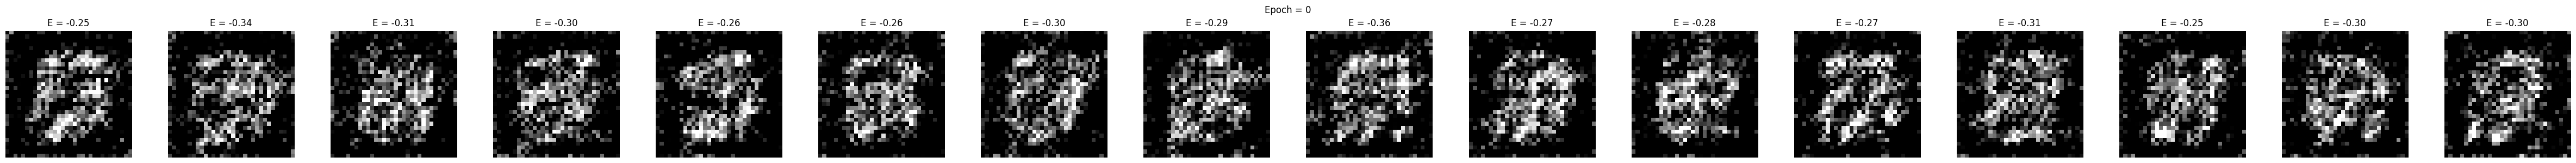

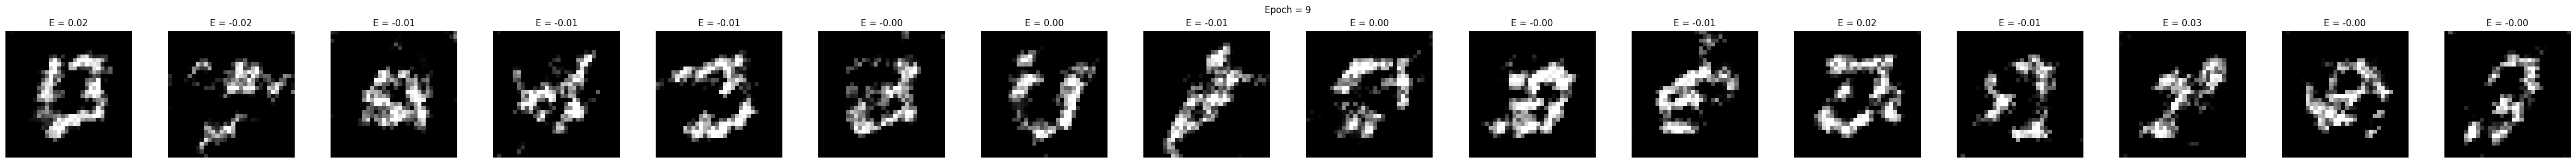

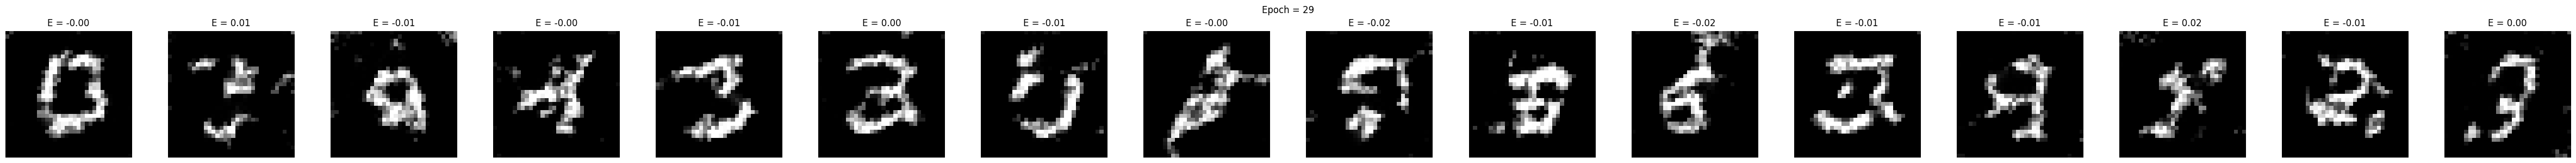

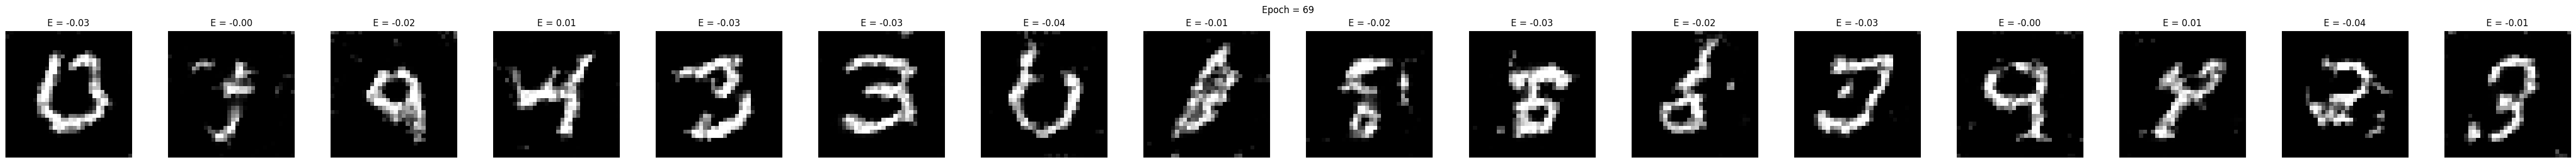

In [24]:
for idx in results:
    imgs = results[idx]["img"] 
    energies = results[idx]["e"] 
    N = imgs.shape[0]
    fig, axes = plt.subplots(1, N, figsize=(N*3, 3))
    if N == 1:
        axes = [axes]
    for i in range(N):
        ax = axes[i]
        img = imgs[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"E = {energies[i]:.2f}")
        ax.axis('off')
    plt.suptitle(f"Epoch = {idx}")
    plt.tight_layout()
    plt.show()

- Observemos cómo cambia el aspecto de las imágenes:
    - Aparecen patrones más definidos
    - Hay menos ruido
    - Se distinguen mejor los dígitos: los bordes son más nítidos y las formas son más claras.

Esto sugiere que conforme pasan las epocas, la función de energía aprende a asignar energías más bajas a las regiones de alta densidad de datos (los dígitos) y energías más altas a las regiones de baja densidad (el ruido).

## 5. Preguntas de análisis (para incluir en su reporte)

- ¿Cómo varía la calidad de las imágenes generadas conforme aumenta el número
de épocas de entrenamiento?
- ¿Qué relación observan entre el número de pasos de Langevin y el nivel de detalle
de las imágenes?
- ¿Qué representa visualmente el “bajar en el paisaje de energía”?

In [25]:
results = {}
ebm = EBM()
max_steps = 200

one_noise_img = initial_noise[0:1, :, :, :]
n_steps = list(range(0, max_steps + (max_steps//10), max_steps//10))

for model_path in checkpoint_files:

    ebm.model = tf.keras.models.load_model(model_path, compile=False)
    n_checkpoint = (int(model_path.split("_")[-1].split(".")[0]))
    ebm.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True)

    images_per_step = []
    for n_step in n_steps:
        sampled_img = generate_samples(
            ebm.model,
            inp_imgs=one_noise_img,
            steps=n_step,
            step_size=10,
            noise=0.005
        )
        images_per_step.append( (sampled_img, ebm.model(sampled_img).numpy().flatten()) )

    results[n_checkpoint] = {
        "img": images_per_step,
    }

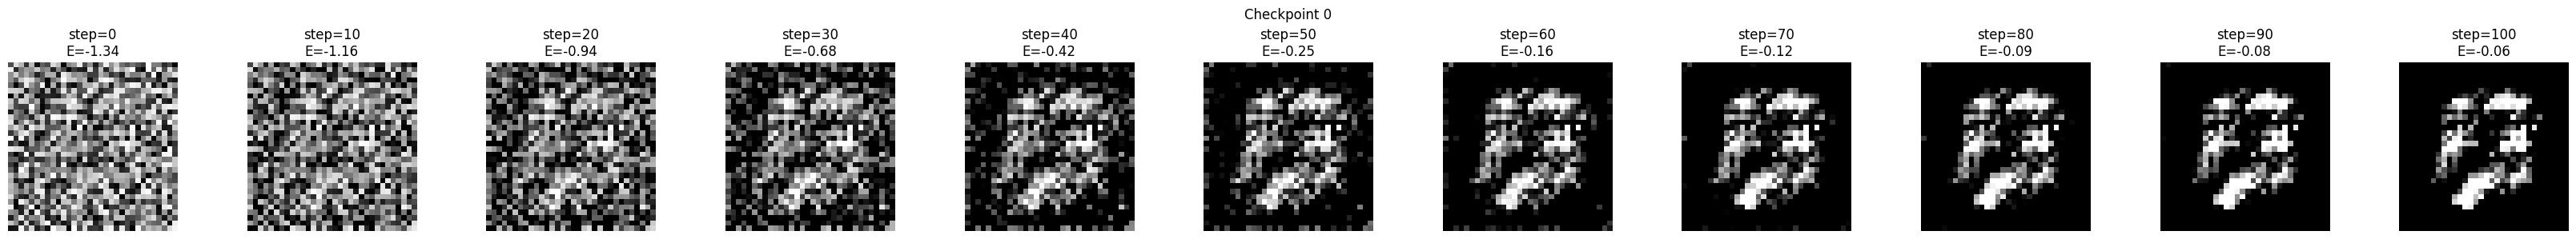

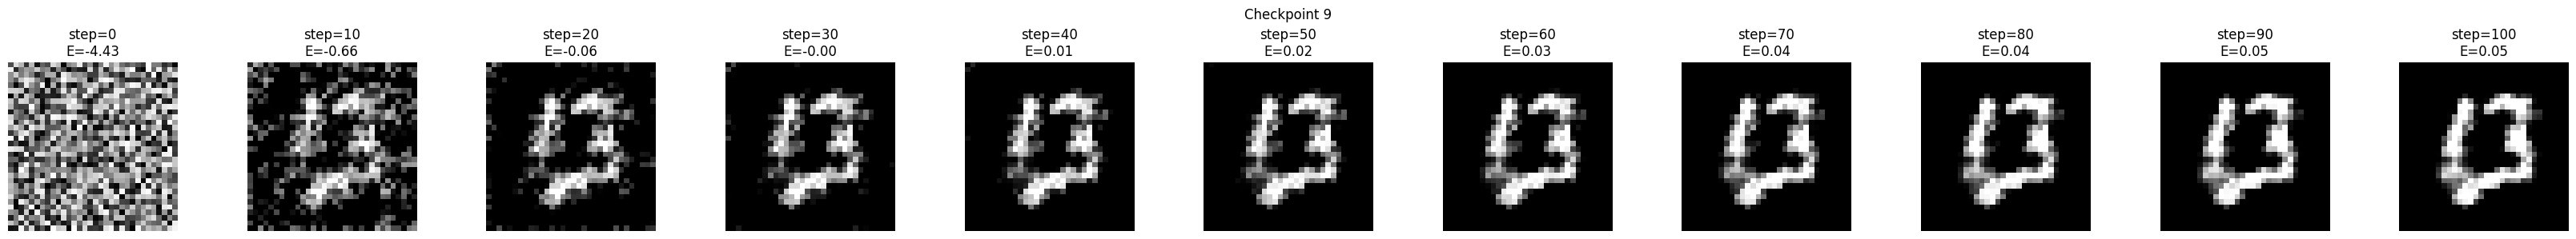

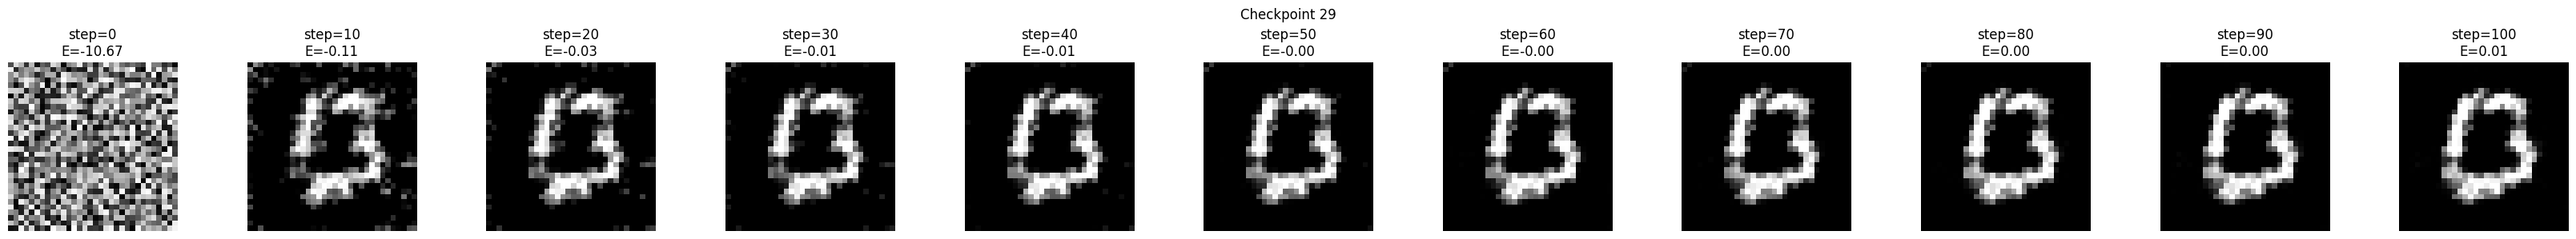

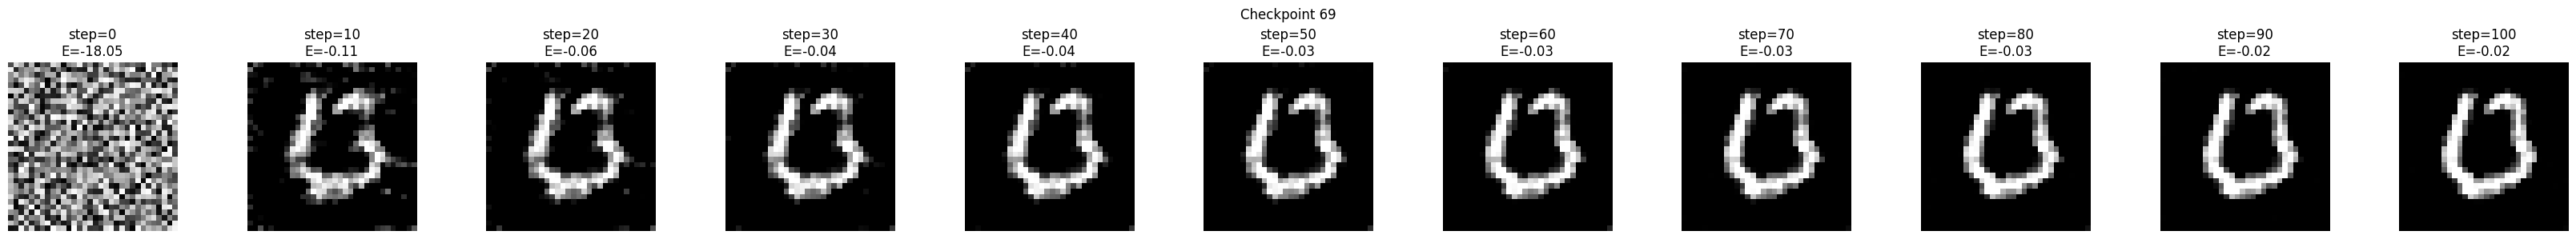

In [26]:
for n_checkpoint in sorted(results.keys()):
    images_per_step = results[n_checkpoint]["img"]
    n_steps = len(images_per_step)
    fig, axes = plt.subplots(1, n_steps, figsize=(n_steps*3, 3))
    if n_steps == 1:
        axes = [axes]
    for i, (sampled_img, energy) in enumerate(images_per_step):
        ax = axes[i]
        img = sampled_img[0] 
        ax.imshow(img, cmap='gray')
        ax.set_title(f"step={i*10}\nE={energy[0]:.2f}")
        ax.axis('off')
    plt.suptitle(f"Checkpoint {n_checkpoint}")
    plt.tight_layout()
    plt.show()


#### ¿Cómo varía la calidad de las imágenes generadas conforme aumenta el número de épocas de entrenamiento?

Conforme aumenta el número de écpoas de entrenamiento, podemos observar que la red va aprendiendo una mejor función de energía en la que se asignan energías más bajas a las imagenes reales y más altas a las falsas. Esto nos permite muestrear mejor utilizando la dinámica de lavengin sobre una mejor función de energía. 

#### ¿Qué relación observan entre el número de pasos de Langevin y el nivel de detalle de las imágenes?

Conforme damos más pasos de Lavengin, vamos bajando cada vez más el ruido inicial hacía regiones de menor energía. Esto nos permite tener imagenes mas reales y con menores ruido. 

#### ¿Qué representa visualmente el “bajar en el paisaje de energía”?

Recordemos que la función de energía asigna zonas de baja energía (valles) a las imagenes reales y altas (picos) a las falsas. Al ir bajando gracias al gradiente estócastico en Lavengin, esto nos permite ir descubriendo zonas más bajas en el paisaje, es decir donde la probabilidad de una imagen real es mayor. 

## 6. Preguntas de análisis

- Realicen interpolaciones entre dos imágenes generadas y describan cómo el
modelo reconfigura la energía a lo largo del trayecto.
- Experimenten con diferentes valores de STEP_SIZE o NOISE y comenten cómo
afectan la convergencia y la diversidad de las muestras.
- Grafiquen la evolución de la energía promedio durante las iteraciones de Langevin
para visualizar el descenso en el paisaje.

#### Efecto sobre STEP_SIZE y NOISE

In [27]:

ebm = EBM()
model_number = -1

ebm.model = tf.keras.models.load_model(checkpoint_files[model_number], compile=False)
n_checkpoint = (int(checkpoint_files[model_number].split("_")[-1].split(".")[0]))

ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

step_sizes = [1, 5, 10, 50]
initial_noise2 = initial_noise[0:16, :, :, :]
all_steps = {}

for n_steps in [50, 100, 500, 10000]:

    results_steps = {}
    for step in step_sizes:

        sampled_imgs = generate_samples(
            ebm.model,
            inp_imgs=initial_noise2,
            steps=100,
            step_size=step,
            noise=0.005
        )

        results_steps[step] = {
            "img": sampled_imgs.numpy(),
            "e": ebm.model(sampled_imgs).numpy().flatten()
        }
    
    all_steps[n_steps] = results_steps


Resultados para n_steps = 50


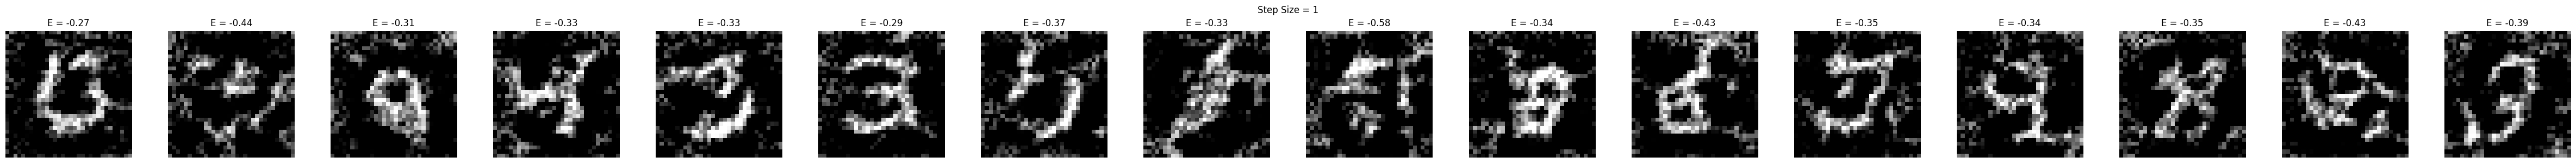

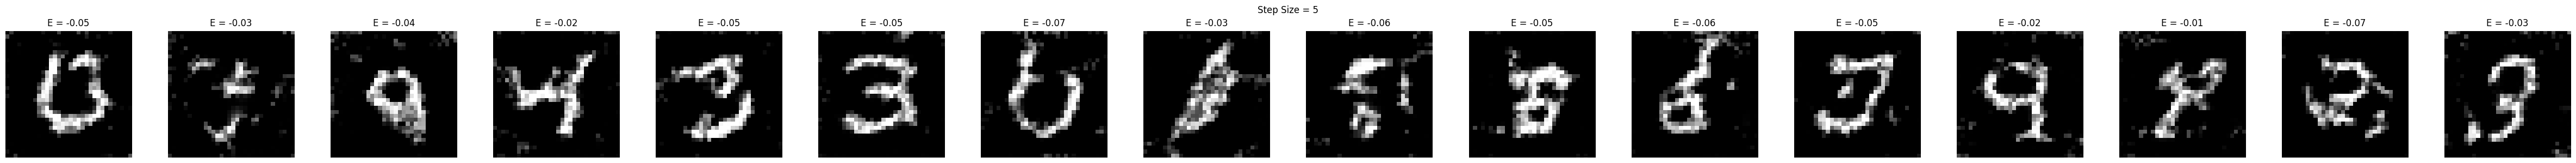

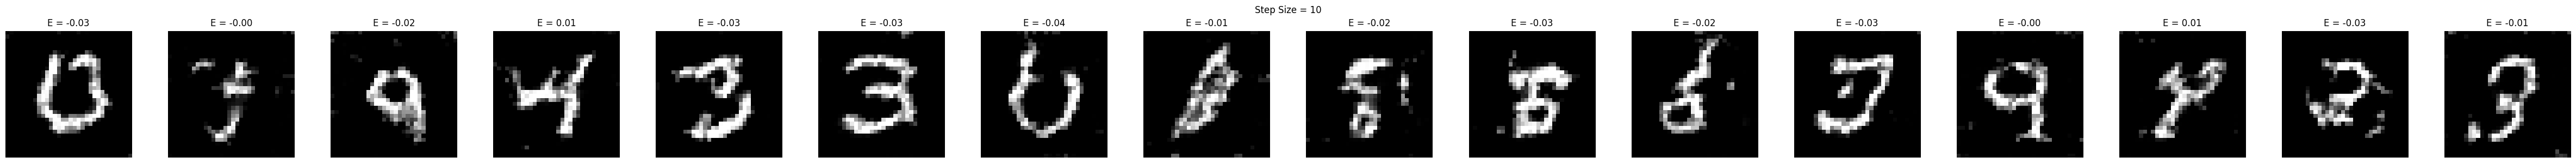

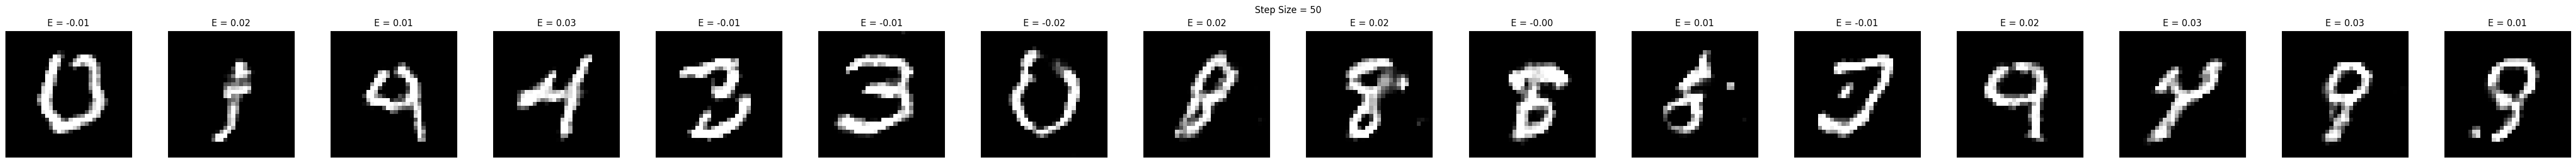

Resultados para n_steps = 100


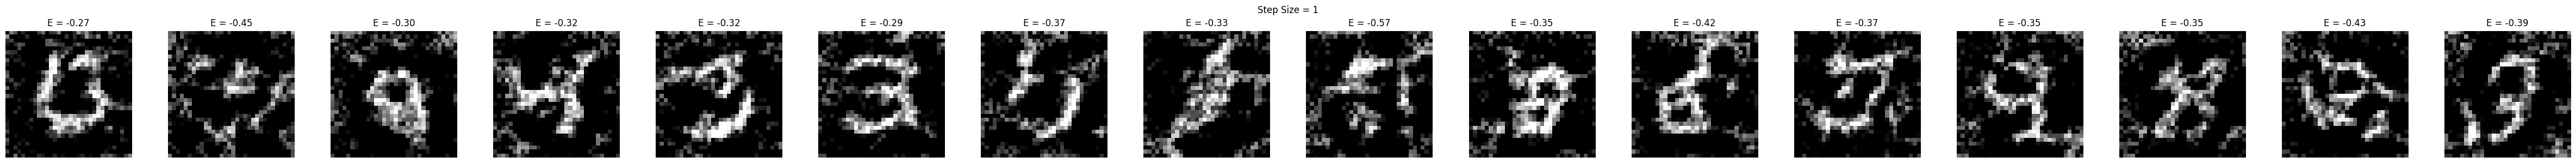

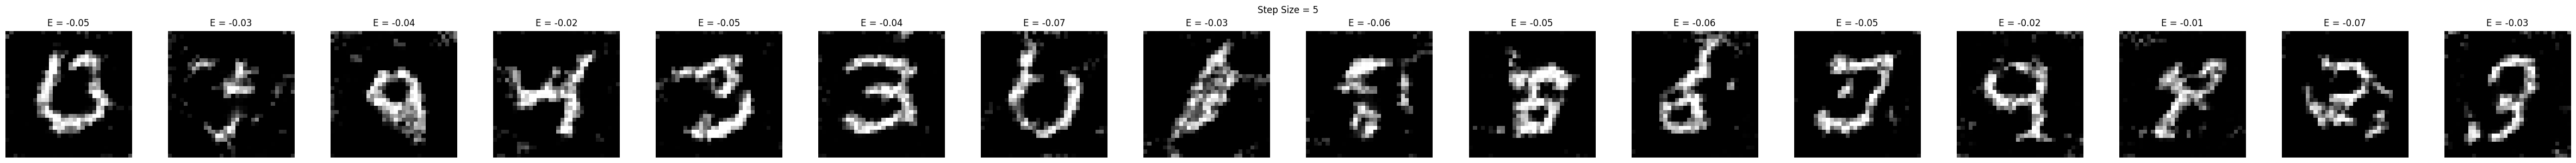

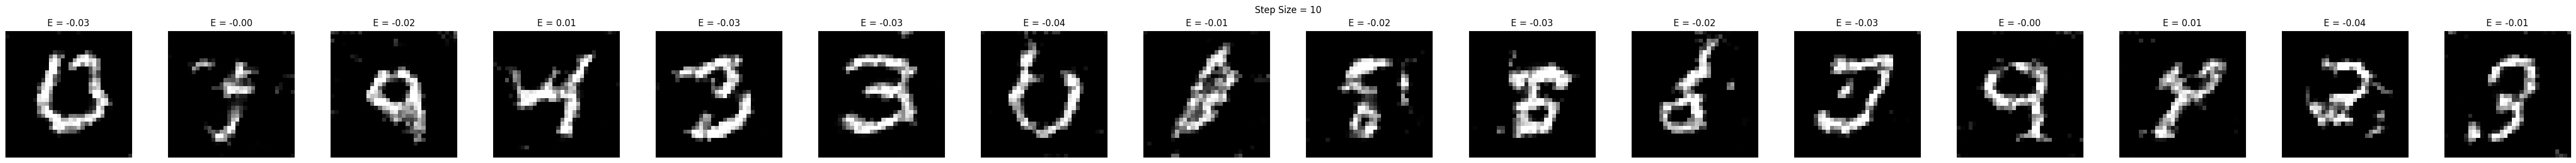

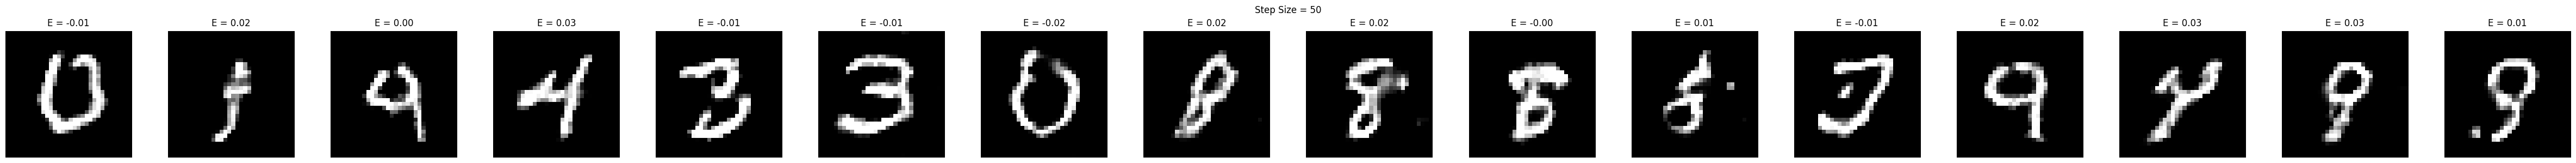

Resultados para n_steps = 500


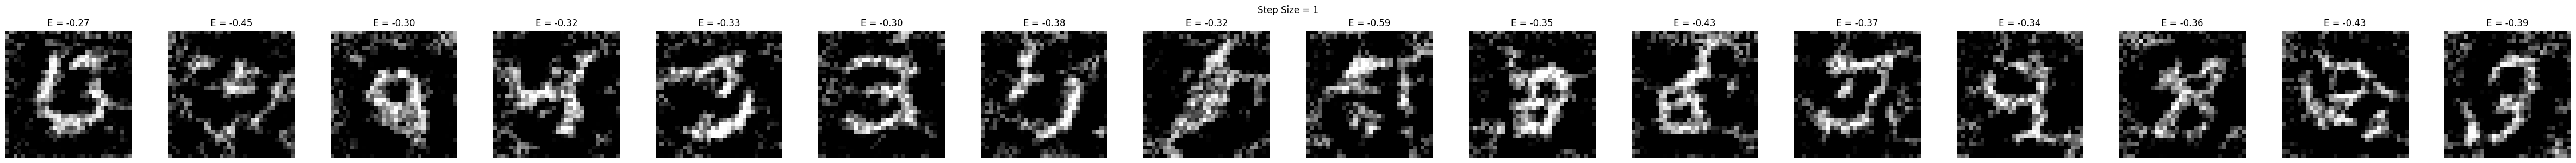

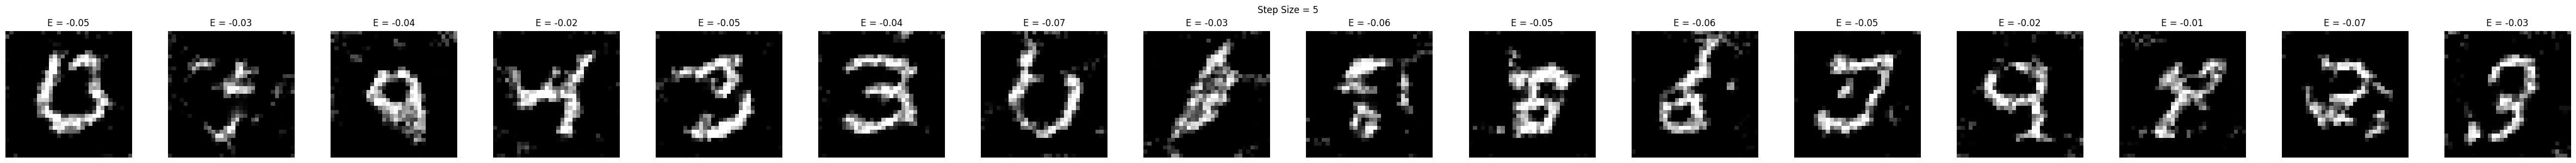

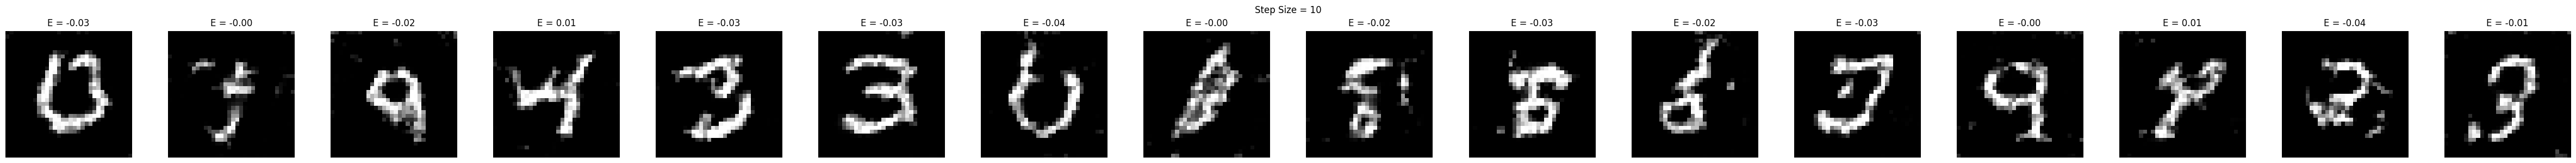

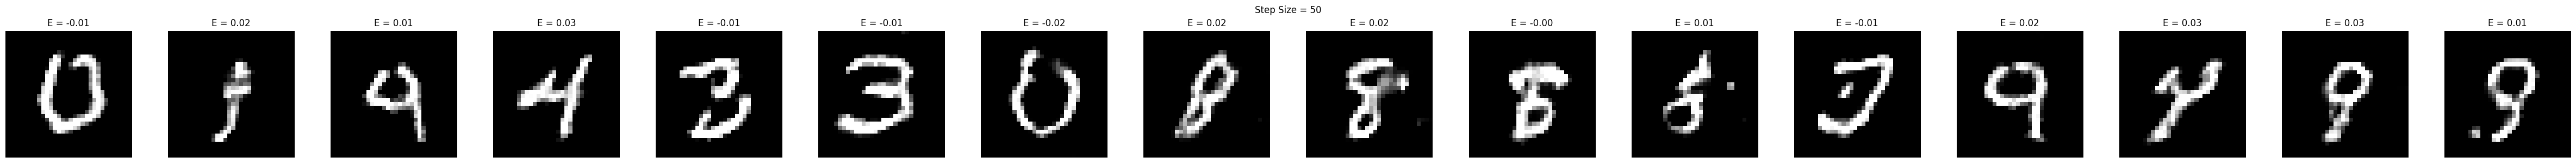

Resultados para n_steps = 10000


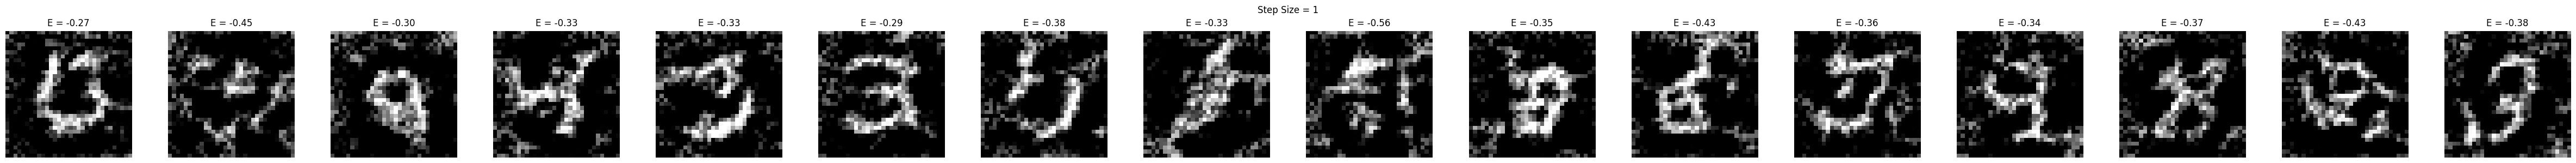

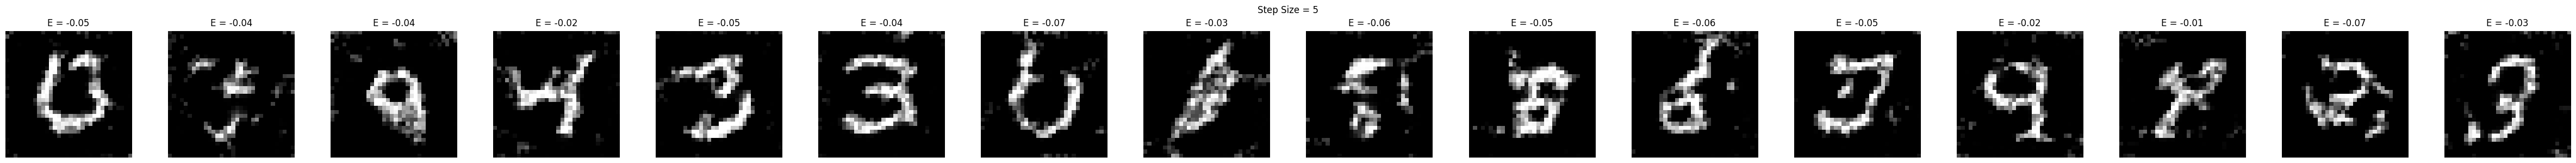

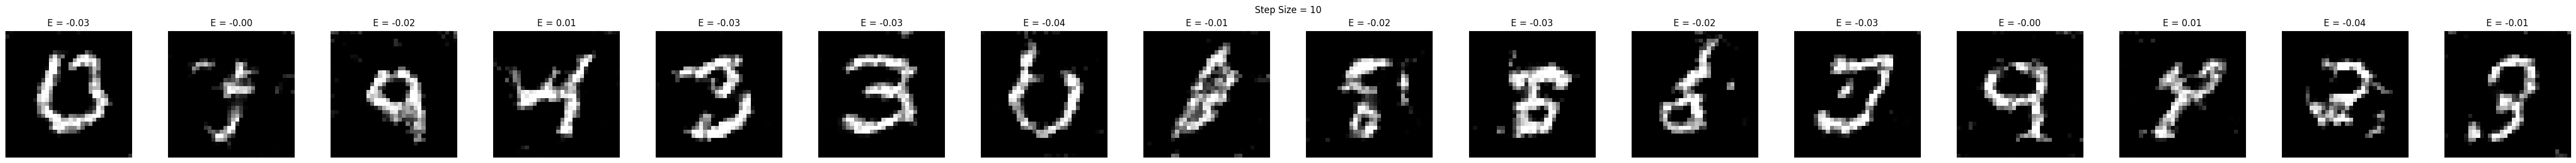

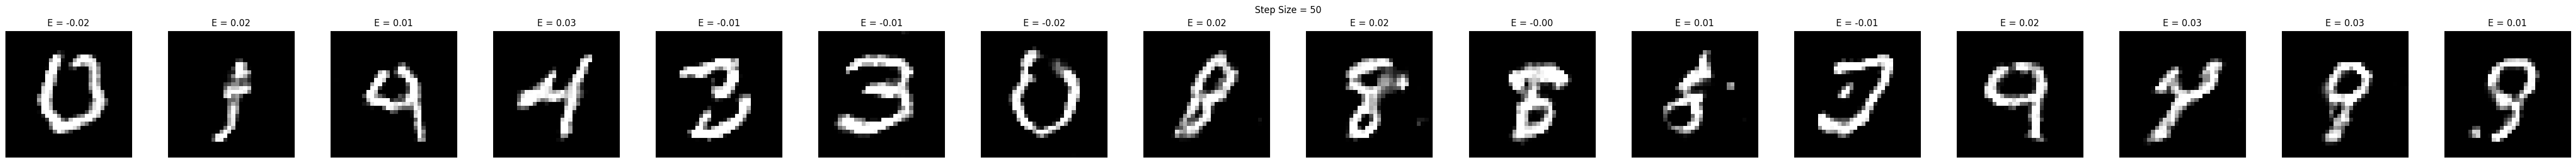

In [28]:
for n_steps in all_steps:
    results_steps = all_steps[n_steps]
    print(f"Resultados para n_steps = {n_steps}")
    for step in results_steps:
        imgs = results_steps[step]["img"] 
        energies = results_steps[step]["e"] 
        N = imgs.shape[0]
        fig, axes = plt.subplots(1, N, figsize=(N*3, 3))
        if N == 1:
            axes = [axes]
        for i in range(N):
            ax = axes[i]
            img = imgs[i]
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(f"E = {energies[i]:.2f}")
            ax.axis('off')
        plt.suptitle(f"Step Size = {step}")
        plt.tight_layout()
        plt.show()

- **STEP_SIZE**: Utilizando pasos más grandes (mayor STEP_SIZE) puede acelerar la convergencia hacia regiones de baja energía, pero también puede hacer que el muestreo sea inestable y salte sobre mínimos locales. Por otro lado, pasos más pequeños permiten un muestreo más fino y estable, pero pueden requerir más iteraciones para converger.

In [29]:

ebm = EBM()
results_noise = {}
model_number = -1

ebm.model = tf.keras.models.load_model(checkpoint_files[model_number], compile=False)
n_checkpoint = (int(checkpoint_files[model_number].split("_")[-1].split(".")[0]))

ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

noise_levels = [0.0, 0.0025, 0.005, 0.01, 0.02, 0.5]
initial_noise2 = initial_noise[0:16, :, :, :]

for noise in noise_levels:

    sampled_imgs = generate_samples(
        ebm.model,
        inp_imgs=initial_noise2,
        steps=50,
        step_size=10,
        noise=noise
    )

    results_noise[noise] = {
        "img": sampled_imgs.numpy(),
        "e": ebm.model(sampled_imgs).numpy().flatten()
    }

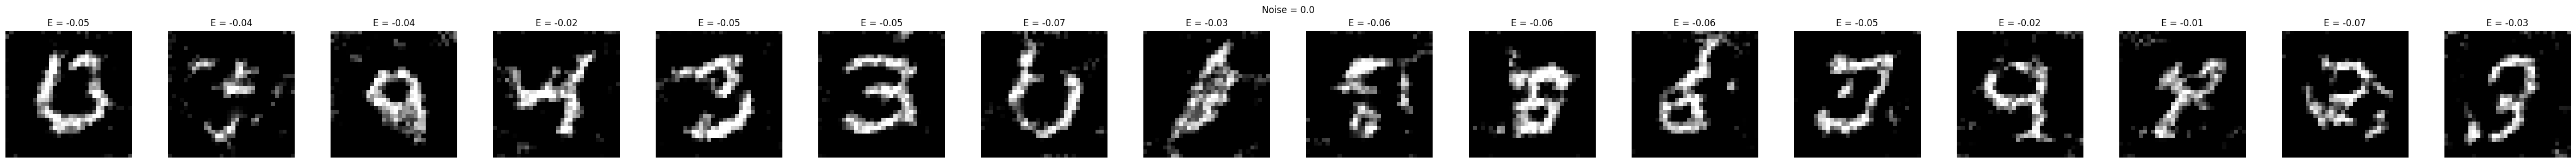

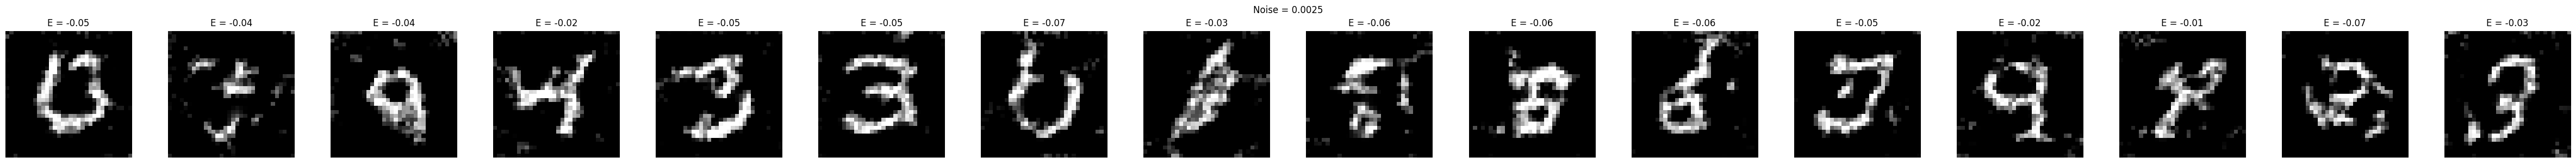

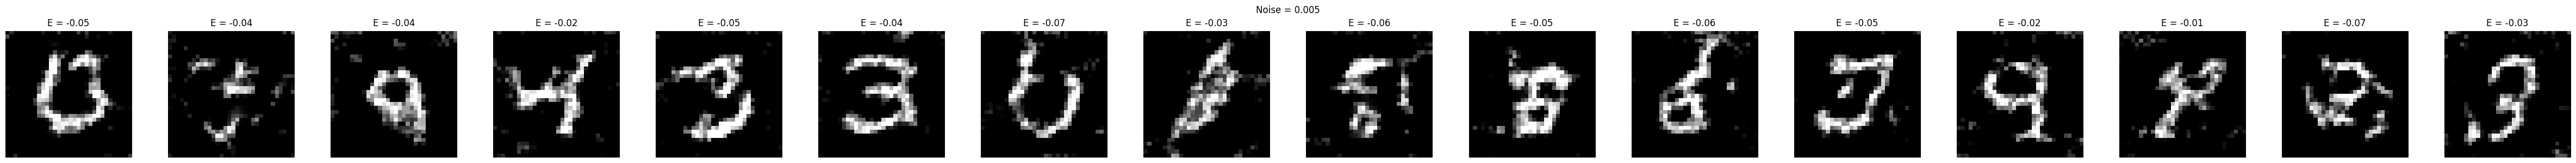

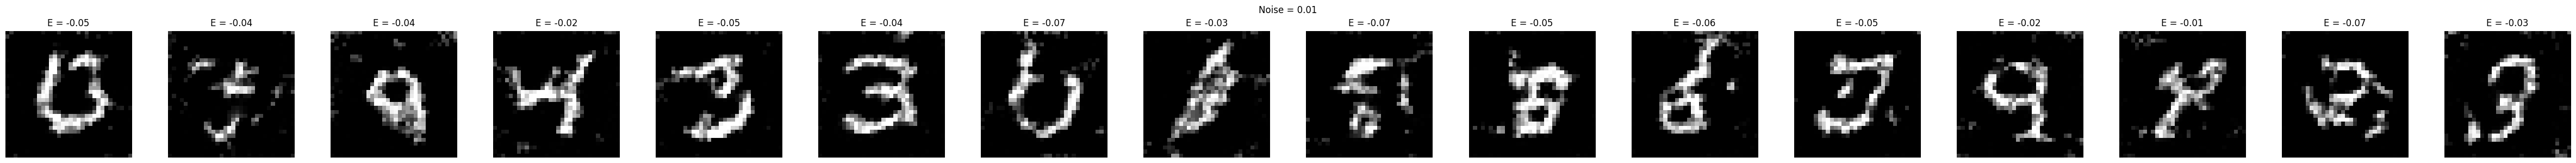

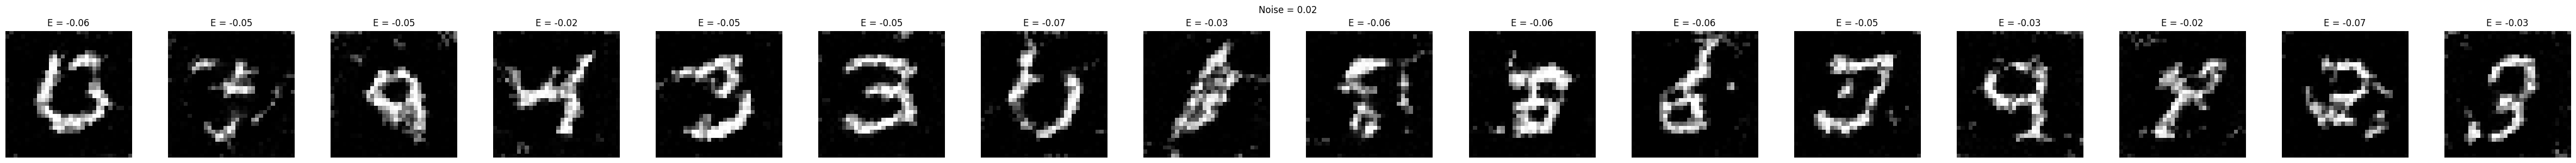

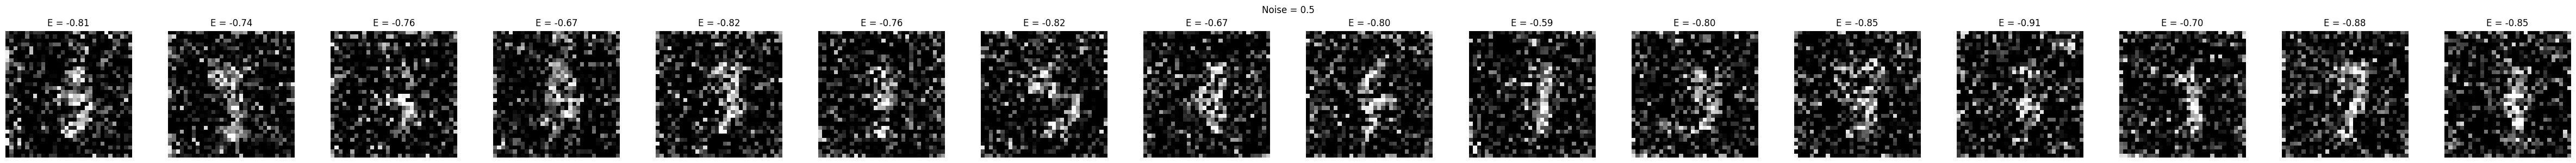

In [30]:
# plot results for different noise levels

for noise in results_noise:
    imgs = results_noise[noise]["img"] 
    energies = results_noise[noise]["e"] 
    N = imgs.shape[0]
    fig, axes = plt.subplots(1, N, figsize=(N*3, 3))
    if N == 1:
        axes = [axes]
    for i in range(N):
        ax = axes[i]
        img = imgs[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"E = {energies[i]:.2f}")
        ax.axis('off')
    plt.suptitle(f"Noise = {noise}")
    plt.tight_layout()
    plt.show()

- **NOISE**: Un valor bajo de NOISE genera muestras más similares entre sí (menos diversidad), mientras que un valor alto aumenta la diversidad pero puede dificultar la convergencia y generar imágenes menos realistas.

Grafiquen la evolución de la energía promedio durante las iteraciones de Langevin
para visualizar el descenso en el paisaje.

In [31]:
results = {}
ebm = EBM()
model_number = -1
n_steps = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 100, 120, 150, 200]

ebm.model = tf.keras.models.load_model(checkpoint_files[model_number], compile=False)
n_checkpoint = (int(checkpoint_files[model_number].split("_")[-1].split(".")[0]))

energies_mean = []

for n_step in n_steps:

    sampled_img = generate_samples(
        ebm.model,
        inp_imgs=initial_noise,
        steps=n_step,
        step_size=10,
        noise=0.005
    )

    energies = ebm.model(sampled_img).numpy().flatten()
    energies_mean.append(np.mean(energies))

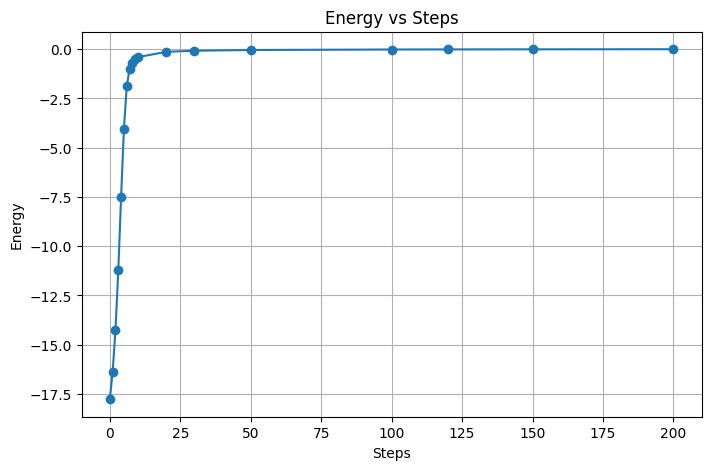

In [32]:
# Plot energies mean vs n_steps
plt.figure(figsize=(8, 5))
plt.plot(n_steps, energies_mean, marker='o')
plt.title('Energy vs Steps')
plt.xlabel('Steps')
plt.ylabel('Energy')
plt.grid()
plt.show()

El valor de 10 pasos escogido en este caso es un buen compromiso entre calidad y tiempo de cómputo. Con 10 pasos, se observa una disminución significativa en la energía promedio, lo que indica que las muestras están convergiendo hacia regiones de menor energía en el paisaje.

Ahora realicemos interpolaciones entre dos imágenes generadas y describamos cómo el
modelo reconfigura la energía a lo largo del trayecto.

In [36]:
ebm = EBM()
ebm.model = tf.keras.models.load_model(checkpoint_files[model_number], compile=False)
n_checkpoint = (int(checkpoint_files[model_number].split("_")[-1].split(".")[0]))

ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

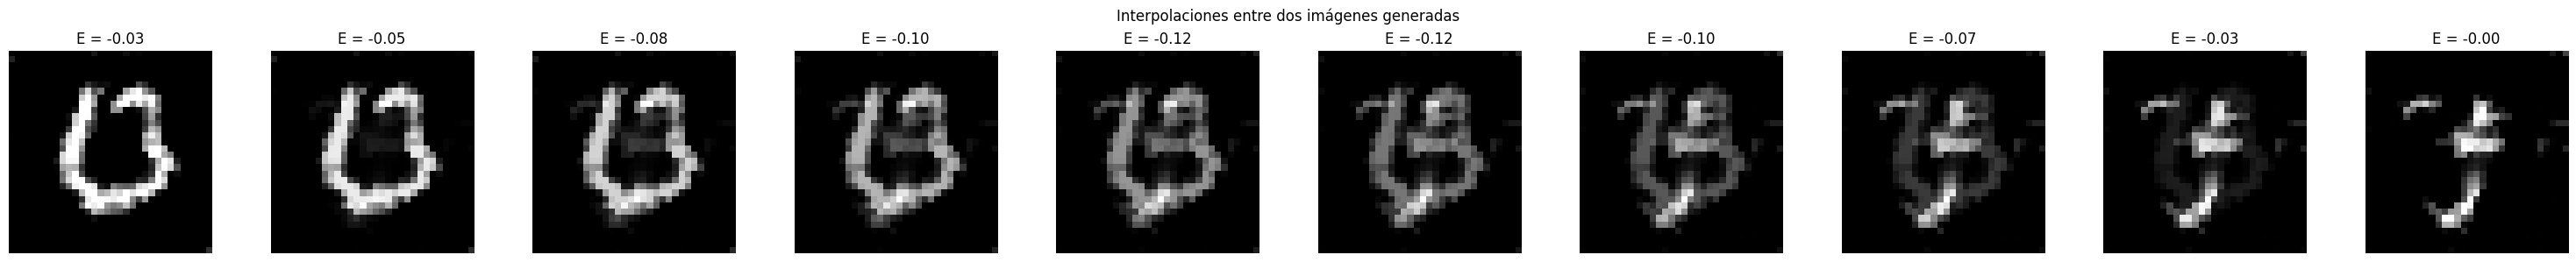

In [38]:
sampled_imgs = generate_samples(
    ebm.model,
    inp_imgs=initial_noise[0:2, :, :, :],
    steps=100,
    step_size=10,
    noise=0.005
)

img1 = sampled_imgs[0:1, :, :, :]
img2 = sampled_imgs[1:2, :, :, :]

# Crear interpolaciones lineales entre img1 y img2
n_interpolations = 10
interpolated_images = []
for alpha in np.linspace(0, 1, n_interpolations):
    interp_img = (1 - alpha) * img1 + alpha * img2
    interpolated_images.append(interp_img)
interpolated_images = tf.stack(interpolated_images, axis=0)
interpolated_images = tf.squeeze(interpolated_images, axis=1)

# Calcular las energías de las imágenes interpoladas
energies = ebm.model(interpolated_images).numpy().flatten()

# Mostrar las imágenes interpoladas con sus energías
N = interpolated_images.shape[0]
fig, axes = plt.subplots(1, N, figsize=(N*3, 3))
if N == 1:
    axes = [axes]
for i in range(N):
    ax = axes[i]
    img = interpolated_images[i]
    ax.imshow(img.numpy().squeeze(), cmap='gray')
    ax.set_title(f"E = {energies[i]:.2f}")
    ax.axis('off')
plt.suptitle("Interpolaciones entre dos imágenes generadas")
plt.tight_layout()
plt.show()